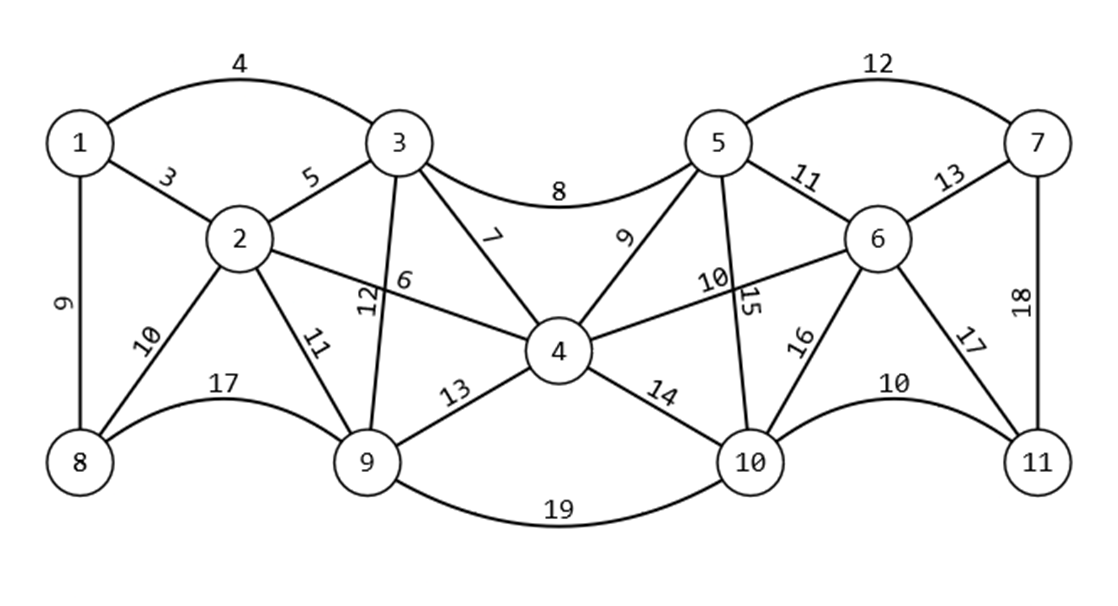

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import permutations

In [2]:
edges = [(1, 3, 4), (1, 2, 3), (1, 8, 9),
         (2, 3, 5), (2, 8, 10), (2, 9, 11), (2, 4, 6),
         (3, 4, 7), (3, 9, 12), (3, 5, 8),
         (4, 9, 13), (4, 5, 9), (4, 10, 14), (4, 6, 10),
         (5, 10, 15), (5, 6, 11), (5, 7, 12),
         (6, 7, 13), (6, 11, 17), (6, 10, 16),
         (7, 11, 18),
         (8, 9, 17),
         (9, 10, 19),
         (10, 11, 10)]

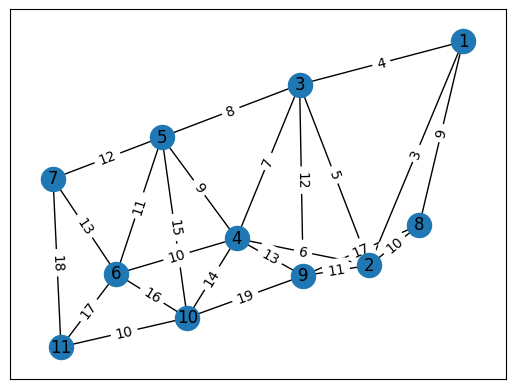

In [3]:
G = nx.Graph()
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, edge_labels=labels, pos=pos);

### Метод ветвей и границ

In [4]:
def branch_and_bound_tsp(graph, start):
    n = len(graph.nodes)
    min_path_cost = float('inf')
    min_path = []

    nodes = list(graph.nodes)
    nodes.remove(start)

    for perm in permutations(nodes):
        path = [start] + list(perm) + [start]
        cost = 0


        for i in range(len(path) - 1):
            if graph.has_edge(path[i], path[i + 1]):
                cost += graph[path[i]][path[i + 1]]['weight']
            else:
                cost = float('inf')
                break

        if cost < min_path_cost:
            min_path_cost = cost
            min_path = path

    return min_path, min_path_cost



In [5]:
start = 1
b_and_b_path, b_and_b_cost = branch_and_bound_tsp(G, start)
print("Путь:", b_and_b_path)
print("Длина:", b_and_b_cost)

Путь: [1, 3, 2, 4, 5, 6, 7, 11, 10, 9, 8, 1]
Длина: 121


### Муравьиный алгоритм

In [6]:
alpha = 1  
beta = 2   
Q = 100    
p = 0.1   
n_ants = 10  
n_iterations = 100 

In [7]:
# инициализаця феромонов
def initialize_pheromones(graph):
    pheromone_map = {}
    for i in graph.nodes():
        pheromone_map[i] = {}
        for j in graph.neighbors(i):
            pheromone_map[i][j] = 1.0
    return pheromone_map

def choose_next_node(current_node, graph, pheromone_map, visited):
    neighbors = list(graph.neighbors(current_node))
    probabilities = []

    for neighbor in neighbors:
        if neighbor not in visited:
            pheromone = pheromone_map[current_node][neighbor]
            distance = 1.0 / graph[current_node][neighbor]['weight']
            probabilities.append((pheromone ** alpha) * (distance ** beta))
        else:
            probabilities.append(0)

    total = sum(probabilities)
    if total == 0:
        return None

    probabilities = [p / total for p in probabilities]
    return np.random.choice(neighbors, p=probabilities)

def ant_colony_tsp(graph, start, n_ants, n_iterations):
    pheromone_map = initialize_pheromones(graph)
    best_path = None
    best_cost = float('inf')

    for _ in range(n_iterations):
        for _ in range(n_ants):
            visited = [start]
            current_node = start
            total_cost = 0

            while len(visited) < len(graph.nodes()):
                next_node = choose_next_node(current_node, graph, pheromone_map, visited)
                if next_node is None:
                    break
                visited.append(next_node)
                total_cost += graph[current_node][next_node]['weight']
                current_node = next_node

            if len(visited) == len(graph.nodes()):
                if start in graph[current_node]:
                    total_cost += graph[current_node][start]['weight']
                    visited.append(start)

                    if total_cost < best_cost:
                        best_cost = total_cost
                        best_path = visited

            # Обновление феромонов
            for i in range(len(visited) - 1):
                pheromone_map[visited[i]][visited[i + 1]] += Q / total_cost

        # Глобальное обновление феромонов
        for i in graph.nodes():
            for j in graph.neighbors(i):
                pheromone_map[i][j] *= (1 - p)  # Испарение феромонов

    return best_path, best_cost

In [8]:
start= 1
a_c_path, a_c_cost = ant_colony_tsp(G, start, n_ants, n_iterations)
print("Путь:", a_c_path)
print("Длина:", a_c_cost)


Путь: [1, np.int64(2), np.int64(4), np.int64(3), np.int64(5), np.int64(6), np.int64(7), np.int64(11), np.int64(10), np.int64(9), np.int64(8), 1]
Длина: 121


### Сравнение методов с разными отправными точками

In [9]:
results = []
for start in G.nodes:
    b_and_b_path, b_and_b_cost = branch_and_bound_tsp(G, start)
    a_c_path, a_c_cost = ant_colony_tsp(G, start, n_ants, n_iterations)

    results.append({
        "start": start,
        "branch_and_bound": (b_and_b_path, b_and_b_cost),
        "ant_colony": (a_c_path, a_c_cost)
    })


for result in results:
    print(f"начало: {result['start']}")
    print(f"  Метод ветвей и границ: Путь: {result['branch_and_bound'][0]}, Длина: {result['branch_and_bound'][1]}")
    print(f"  Муравьиный алгоритм: Путь: {result['ant_colony'][0]}, Длина: {result['ant_colony'][1]}")
    print()


начало: 1
  Метод ветвей и границ: Путь: [1, 3, 2, 4, 5, 6, 7, 11, 10, 9, 8, 1], Длина: 121
  Муравьиный алгоритм: Путь: [1, np.int64(2), np.int64(4), np.int64(6), np.int64(10), np.int64(11), np.int64(7), np.int64(5), np.int64(3), np.int64(9), np.int64(8), 1], Длина: 121

начало: 3
  Метод ветвей и границ: Путь: [3, 1, 2, 8, 9, 4, 10, 11, 6, 7, 5, 3], Длина: 121
  Муравьиный алгоритм: Путь: [3, np.int64(5), np.int64(6), np.int64(7), np.int64(11), np.int64(10), np.int64(4), np.int64(2), np.int64(1), np.int64(8), np.int64(9), 3], Длина: 121

начало: 2
  Метод ветвей и границ: Путь: [2, 1, 3, 4, 5, 6, 7, 11, 10, 9, 8, 2], Длина: 121
  Муравьиный алгоритм: Путь: [2, np.int64(1), np.int64(3), np.int64(5), np.int64(10), np.int64(11), np.int64(7), np.int64(6), np.int64(4), np.int64(9), np.int64(8), 2], Длина: 121

начало: 8
  Метод ветвей и границ: Путь: [8, 1, 3, 2, 4, 5, 6, 7, 11, 10, 9, 8], Длина: 121
  Муравьиный алгоритм: Путь: [8, np.int64(1), np.int64(2), np.int64(3), np.int64(5), np.i